## BERTopic

In [2]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import os

import nltk
from nltk.corpus import PlaintextCorpusReader

KeyboardInterrupt: 

In [ ]:
import preprocess2
reviews_corpus = preprocess2.load_corpus('sephora_corpus')
reviews_docs = preprocess2.corpus2docs(reviews_corpus)


# Build the bigram and trigram models
bigram = gensim.models.Phrases(reviews_docs, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(reviews_docs)

reviews_docs_joined = [" ".join(x) for x in data_words_bigrams]

In [ ]:
# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(docs)

# Create our vocabulary
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

In [3]:
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

c:\Users\leele\anaconda3\envs\TAA2023\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
topic_model = BERTopic(verbose=True, n_gram_range=(1,1))
topics, _ = topic_model.fit_transform(reviews_docs_joined); len(topic_model.get_topic_info())

Batches: 100%|██████████| 2805/2805 [08:52<00:00,  5.27it/s]
2023-11-01 10:52:41,189 - BERTopic - Transformed documents to Embeddings
2023-11-01 10:55:07,624 - BERTopic - Reduced dimensionality
2023-11-01 10:55:19,431 - BERTopic - Clustered reduced embeddings


369

In [5]:
import numpy as np
from bertopic import BERTopic
from gensim import corpora
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
from hdbscan import HDBSCAN
from umap import UMAP
import gensim.corpora as corpora
import pandas as pd
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the range of parameters
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Dimensionality Reduction Parameters
n_neighbors_range = [5, 10, 15]
n_components_range = [3, 5, 7]

model_results = {'Topics': [],
                 'N_Neighbors': [],
                 'N_Components': [],
                 'Coherence': []
                }

# Define the size of the subset (10%)
subset_size = int(len(reviews_docs_joined) * 0.1)
subset_docs = np.random.choice(reviews_docs_joined, subset_size, replace=False)

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range) * len(n_neighbors_range) * len(n_components_range)))

for k in topics_range:
    for n_neighbors in n_neighbors_range:
        for n_components in n_components_range:
            # Initialize the BERTopic model with specified hyperparameters
            embedding_model = SentenceTransformer('all-mpnet-base-v2')
            umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components, metric='manhattan', low_memory=True)
            hdbscan_model = HDBSCAN()
            vectorizer_model = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
            ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
            representation_model = KeyBERTInspired()
            
            # Create the BERTopic model
            topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)
            
            # Fit the model on your subset of documents
            topics, _ = topic_model.fit_transform(subset_docs)
            
            # Preprocess documents
            documents = pd.DataFrame(
                {"Document": subset_docs,
                 "ID": range(len(subset_docs)),
                 "Topic": topics}
            )
            documents_per_topic = documents.groupby(
                ['Topic'], as_index=False).agg({'Document': ' '.join})
            cleaned_docs = topic_model._preprocess_text(
                documents_per_topic.Document.values)
            
            # Extract vectorizer and analyzer from the fitted model
            vectorizer_model = topic_model.vectorizer_model
            analyzer = vectorizer_model.build_analyzer()
            
            # Extract features for topic coherence evaluation
            tokens = [analyzer(doc) for doc in cleaned_docs]
            dictionary = corpora.Dictionary(tokens)
            corpus = [dictionary.doc2bow(token) for token in tokens]
            topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics)) - 1)]
            
            # Calculate coherence
            coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            
            # Save the model results
            model_results['Topics'].append(k)
            model_results['N_Neighbors'].append(n_neighbors)
            model_results['N_Components'].append(n_components)
            model_results['Coherence'].append(coherence_score)

            pbar.update(1)
    pbar.close()

  0%|          | 0/81 [00:00<?, ?it/s]2023-11-01 11:03:15,116 - BERTopic - Transformed documents to Embeddings
2023-11-01 11:03:29,986 - BERTopic - Reduced dimensionality
2023-11-01 11:03:30,180 - BERTopic - Clustered reduced embeddings
  1%|          | 1/81 [07:14<9:39:41, 434.77s/it]2023-11-01 11:10:09,152 - BERTopic - Transformed documents to Embeddings
2023-11-01 11:10:15,905 - BERTopic - Reduced dimensionality
2023-11-01 11:10:16,138 - BERTopic - Clustered reduced embeddings
  2%|▏         | 2/81 [14:01<9:10:51, 418.37s/it]2023-11-01 11:17:38,895 - BERTopic - Transformed documents to Embeddings
2023-11-01 11:17:47,444 - BERTopic - Reduced dimensionality
2023-11-01 11:17:47,859 - BERTopic - Clustered reduced embeddings
  4%|▎         | 3/81 [23:49<10:44:16, 495.60s/it]2023-11-01 11:29:58,010 - BERTopic - Transformed documents to Embeddings
2023-11-01 11:30:13,392 - BERTopic - Reduced dimensionality
2023-11-01 11:30:13,842 - BERTopic - Clustered reduced embeddings
  5%|▍         | 4

In [6]:
pd.DataFrame(model_results).to_csv('./bertopic_tuning_results2.csv', index=False)

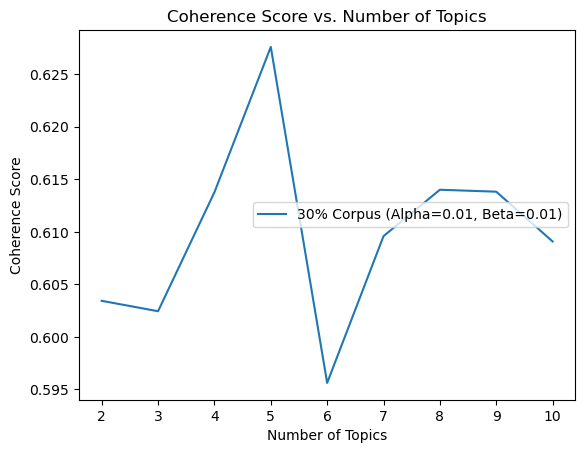

In [9]:
import matplotlib.pyplot as plt

# Extract the data for plotting
topics = model_results['Topics']
coherence_scores = model_results['Coherence']
neighbors_values = model_results['N_Neighbors']
components_values = model_results['N_Components']

# Filter the data 
filtered_indices = [(neighbors == 5) and (components == 3) for neighbors, components in zip(neighbors_values, components_values)]

filtered_topics = [topics[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]
filtered_coherence_scores = [coherence_scores[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot coherence scores for the filtered data
ax.plot(filtered_topics, filtered_coherence_scores, label='30% Corpus (Alpha=0.01, Beta=0.01)')

# Set labels and title
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Score vs. Number of Topics')

# Display a legend
ax.legend()

# Show the plot
plt.show()